# Milestone 2

In [1]:
from cProfile import label

from altair import XOffset
from matplotlib.pyplot import ylabel, title
from networkx.algorithms.bipartite.basic import color
from scipy.stats import binned_statistic
from streamlit import columns
%load_ext autoreload
%autoreload 2

In [2]:
# all imports
from src import *
import pandas as pd
import os.path

## Data acquisition

In [3]:
filename = './data/dataframe_2016_to_2019.csv'
start_year = 2016
end_year = 2019

if not os.path.isfile(filename):
    # Get the data from the NHL API (2016 - 2019)
    nhl_data_provider = get_data_from(start_year, end_year)

    # Clean the data
    clean_regular_season, clean_playoff = clean_data(nhl_data_provider)

    # Transform data into dataframe
    df_2016_to_2019 = convert_dictionaries_to_dataframes(clean_regular_season,
                                                     clean_playoff,
                                                     np.arange(start_year, end_year + 1).tolist())
    df_2016_to_2019.to_csv(filename, index=False)

Data was successfully imported: data/regular_season/2016\2016_0001.json
Data was successfully imported: data/regular_season/2016\2016_0002.json
Data was successfully imported: data/regular_season/2016\2016_0003.json
Data was successfully imported: data/regular_season/2016\2016_0004.json
Data was successfully imported: data/regular_season/2016\2016_0005.json
Data was successfully imported: data/regular_season/2016\2016_0006.json
Data was successfully imported: data/regular_season/2016\2016_0007.json
Data was successfully imported: data/regular_season/2016\2016_0008.json
Data was successfully imported: data/regular_season/2016\2016_0009.json
Data was successfully imported: data/regular_season/2016\2016_0010.json
Data was successfully imported: data/regular_season/2016\2016_0011.json
Data was successfully imported: data/regular_season/2016\2016_0012.json
Data was successfully imported: data/regular_season/2016\2016_0013.json
Data was successfully imported: data/regular_season/2016\2016_00

In [4]:
train_data = pd.read_csv(filename)

# Ingénierie des caractéristiques

## Question 1

In [5]:
train_data

,Year,idGame,gameType,periodType,currentPeriod,timeInPeriod,eventOwnerTeam,typeDescKey,iceCoord,zoneShoot,shootingPlayer,goaliePlayer,shotType,teamSide,emptyGoalNet,isGoalAdvantage,shotDistance,shotAngle,timeSinceLastShot
0,2016,2016020001,regular-season,REG,1/3,2016-10-12 23:01:11+00:00,Maple Leafs,shot-on-goal,"(-77, 5)",O,Mitch Marner,Craig Anderson,wrist,away,False,Neutral,13.0,22.619865,0:00
1,2016,2016020001,regular-season,REG,1/3,2016-10-12 23:02:53+00:00,Senators,shot-on-goal,"(86, 13)",O,Chris Kelly,Frederik Andersen,wrist,home,False,Neutral,13.3,77.005383,0:00
2,2016,2016020001,regular-season,REG,1/3,2016-10-12 23:04:01+00:00,Senators,shot-on-goal,"(23, -38)",N,Cody Ceci,Frederik Andersen,wrist,home,False,Neutral,76.2,29.931512,1:08
3,2016,2016020001,regular-season,REG,1/3,2016-10-12 23:04:46+00:00,Senators,shot-on-goal,"(33, -15)",O,Erik Karlsson,Frederik Andersen,slap,home,False,Neutral,58.0,14.995079,0:45
4,2016,2016020001,regular-season,REG,1/3,2016-10-12 23:06:46+00:00,Maple Leafs,shot-on-goal,"(-34, 28)",O,Martin Marincin,Craig Anderson,wrist,away,False,Neutral,61.7,26.980231,5:35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
327337,2019,2019030416,playoffs,REG,3/3,2020-09-29 00:56:01+00:00,Lightning,shot-on-goal,"(-59, -24)",O,Anthony Cirelli,Anton Khudobin,snap,away,False,Disadvantage,38.4,38.659808,7:30
327338,2019,2019030416,playoffs,REG,3/3,2020-09-29 00:57:20+00:00,Lightning,shot-on-goal,"(-81, 3)",O,Blake Coleman,Anton Khudobin,wrist,away,False,Disadvantage,8.5,20.556045,1:19
327339,2019,2019030416,playoffs,REG,3/3,2020-09-29 00:58:50+00:00,Stars,shot-on-goal,"(34, -6)",O,John Klingberg,Andrei Vasilevskiy,snap,home,False,Advantage,55.3,6.225829,3:23
327340,2019,2019030416,playoffs,REG,3/3,2020-09-29 00:59:27+00:00,Stars,shot-on-goal,"(31, 10)",O,John Klingberg,Andrei Vasilevskiy,wrist,home,False,Advantage,58.9,9.782407,0:37


In [6]:
train_data['isGoal'] = train_data['typeDescKey'].apply(lambda x: 1 if x == 'goal' else 0)

train_data['emptyGoalNet_0_1'] = train_data['emptyGoalNet'].astype(int)

train_data

,Year,idGame,gameType,periodType,currentPeriod,timeInPeriod,eventOwnerTeam,typeDescKey,iceCoord,zoneShoot,...,goaliePlayer,shotType,teamSide,emptyGoalNet,isGoalAdvantage,shotDistance,shotAngle,timeSinceLastShot,isGoal,emptyGoalNet_0_1
0,2016,2016020001,regular-season,REG,1/3,2016-10-12 23:01:11+00:00,Maple Leafs,shot-on-goal,"(-77, 5)",O,...,Craig Anderson,wrist,away,False,Neutral,13.0,22.619865,0:00,0,0
1,2016,2016020001,regular-season,REG,1/3,2016-10-12 23:02:53+00:00,Senators,shot-on-goal,"(86, 13)",O,...,Frederik Andersen,wrist,home,False,Neutral,13.3,77.005383,0:00,0,0
2,2016,2016020001,regular-season,REG,1/3,2016-10-12 23:04:01+00:00,Senators,shot-on-goal,"(23, -38)",N,...,Frederik Andersen,wrist,home,False,Neutral,76.2,29.931512,1:08,0,0
3,2016,2016020001,regular-season,REG,1/3,2016-10-12 23:04:46+00:00,Senators,shot-on-goal,"(33, -15)",O,...,Frederik Andersen,slap,home,False,Neutral,58.0,14.995079,0:45,0,0
4,2016,2016020001,regular-season,REG,1/3,2016-10-12 23:06:46+00:00,Maple Leafs,shot-on-goal,"(-34, 28)",O,...,Craig Anderson,wrist,away,False,Neutral,61.7,26.980231,5:35,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
327337,2019,2019030416,playoffs,REG,3/3,2020-09-29 00:56:01+00:00,Lightning,shot-on-goal,"(-59, -24)",O,...,Anton Khudobin,snap,away,False,Disadvantage,38.4,38.659808,7:30,0,0
327338,2019,2019030416,playoffs,REG,3/3,2020-09-29 00:57:20+00:00,Lightning,shot-on-goal,"(-81, 3)",O,...,Anton Khudobin,wrist,away,False,Disadvantage,8.5,20.556045,1:19,0,0
327339,2019,2019030416,playoffs,REG,3/3,2020-09-29 00:58:50+00:00,Stars,shot-on-goal,"(34, -6)",O,...,Andrei Vasilevskiy,snap,home,False,Advantage,55.3,6.225829,3:23,0,0
327340,2019,2019030416,playoffs,REG,3/3,2020-09-29 00:59:27+00:00,Stars,shot-on-goal,"(31, 10)",O,...,Andrei Vasilevskiy,wrist,home,False,Advantage,58.9,9.782407,0:37,0,0


In [7]:
count_table = pd.crosstab(train_data['isGoal'],train_data['typeDescKey'])
# count_table2 = pd.crosstab(train_data['emptyGoalNet_0_1'],train_data['emptyGoalNet'])

count_table
# count_table2

typeDescKey,goal,shot-on-goal
isGoal,,
0,0,296406
1,30936,0


#### Histogramme du nombre de tirs (buts et non-buts séparés), regroupés par distance

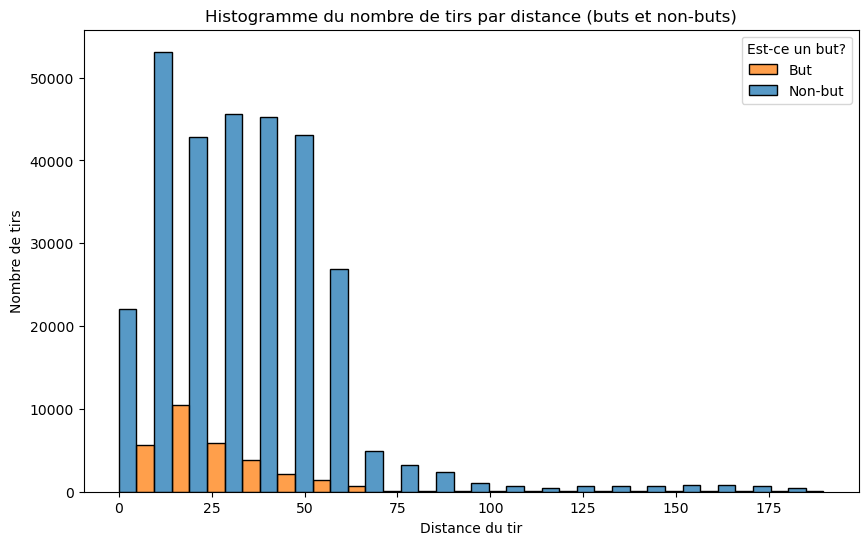

In [8]:
## Add in advancedVisualisation (by Youry)
def histogram_2_variables(df, x, hue, bins, xlabel, ylabel, title, legendTitle, legendLabels):
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df, x=x, hue=hue, bins=bins, multiple='dodge')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend(title=legendTitle, labels=legendLabels)
    plt.show()
    
histogram_2_variables(df=train_data, x='shotDistance', hue='isGoal', bins=20, xlabel='Distance du tir', ylabel='Nombre de tirs', title='Histogramme du nombre de tirs par distance (buts et non-buts)', legendTitle='Est-ce un but?', legendLabels=['But', 'Non-but'])

#### Histogramme du nombre de tirs (buts et non-buts séparés), regroupés par angle

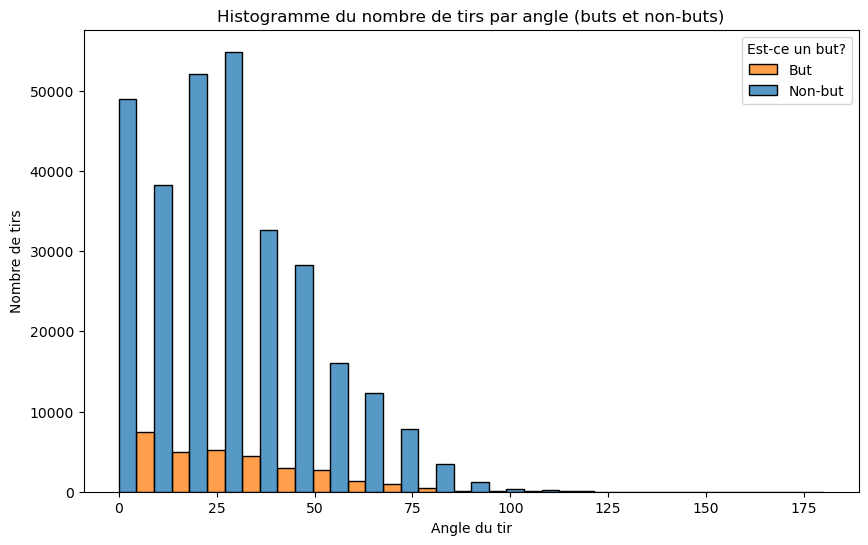

In [9]:
histogram_2_variables(train_data, x='shotAngle', hue='isGoal', bins=20, xlabel='Angle du tir', ylabel='Nombre de tirs', title='Histogramme du nombre de tirs par angle (buts et non-buts)', legendTitle='Est-ce un but?', legendLabels=['But', 'Non-but'])

#### Histogramme 2D où un axe est la distance et l'autre est l'angle (sans distinction entre buts et non-buts)

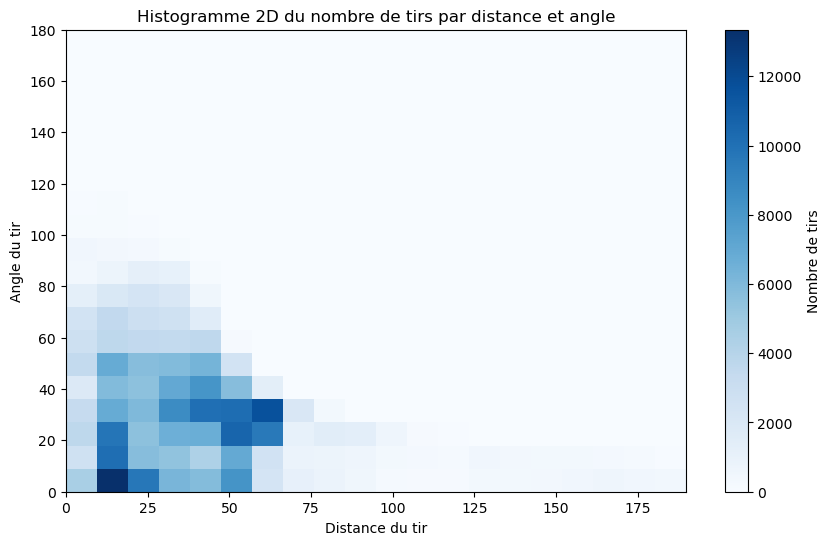

In [10]:
def histogram2D_2_variables(df, x, y, bins, label, xlabel, ylabel, title):
    # Remove rows with NaN values
    df = df.dropna(subset=[x, y])    
    # Plot the histogram with hue for 'is_goal'
    plt.figure(figsize=(10, 6))
    plt.hist2d(df[x], df[y], bins=bins, cmap='Blues')    
    # Customize legend labels for hue values
    plt.colorbar(label=label)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

histogram2D_2_variables(train_data, x='shotDistance', y='shotAngle', bins=20, label='Nombre de tirs', xlabel='Distance du tir', ylabel='Angle du tir', title='Histogramme 2D du nombre de tirs par distance et angle')

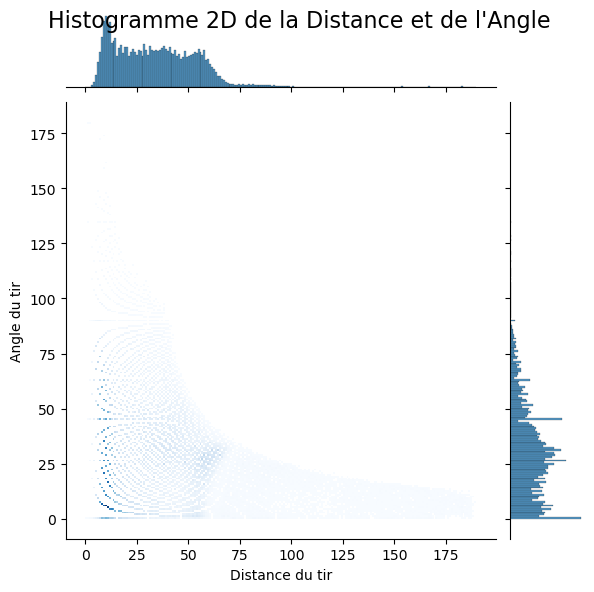

In [11]:
def histogram2D_2_variables_seaborn(df, x, y, kind, title, xlabel, ylabel):    
    # Remove rows with NaN values
    df = df.dropna(subset=[x, y])
    # Jointplot to visualize the 2D histogram
    sns.jointplot(data=df, x=x, y=y, kind=kind, cmap='Blues')    
    # Add title and labels
    plt.suptitle(title, fontsize=16)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)    
    # Show the plot
    plt.show()

histogram2D_2_variables_seaborn(train_data, x='shotDistance', y='shotAngle', kind='hist', title="Histogramme 2D de la Distance et de l'Angle", xlabel='Distance du tir', ylabel='Angle du tir')

## Question 2

#### Le taux de but (buts / (buts + non-buts)) par distance

In [12]:
df_distance_goal_rate = train_data.groupby('shotDistance')['isGoal'].mean().reset_index()
df_distance_goal_rate.columns = ['shotDistance', 'goalRate']

df_distance_goal_rate


,shotDistance,goalRate
0,0.0,1.000000
1,1.0,1.000000
2,1.4,0.777778
3,2.0,0.500000
4,2.2,0.550000
...,...,...
1769,188.0,0.500000
1770,188.1,0.000000
1771,188.2,0.000000
1772,188.4,0.000000


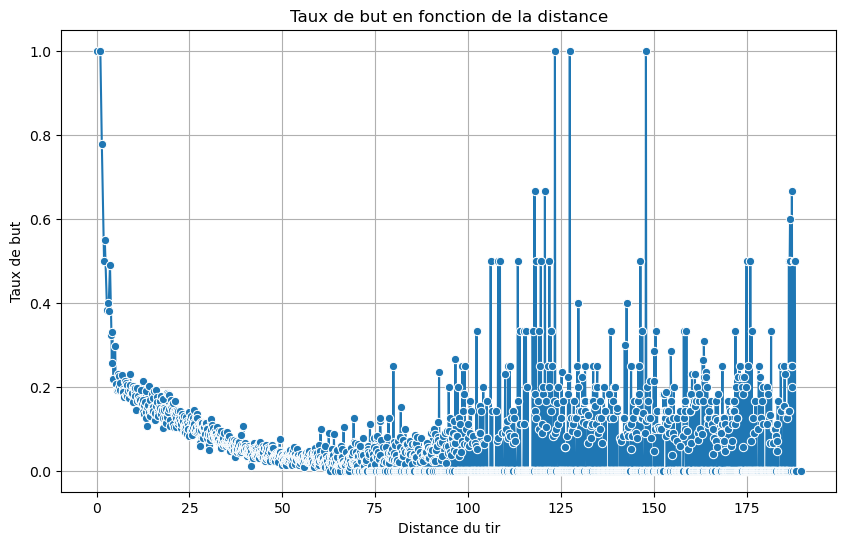

In [13]:
def lineplot_2_variables(df, x, y, title, xlabel, ylabel):
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=df, x=x, y=y, marker='o')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True)
    plt.show()

lineplot_2_variables(df=df_distance_goal_rate, x='shotDistance', y='goalRate', title='Taux de but en fonction de la distance', xlabel='Distance du tir', ylabel='Taux de but')

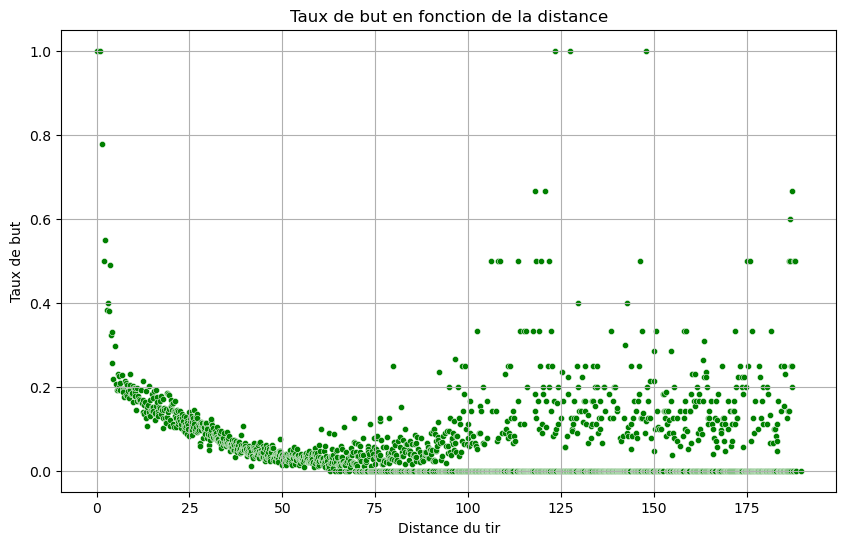

In [14]:
def scatterplot_2_variables(df, x, y, color, s, title, xlabel, ylabel):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df, x=x, y=y, color=color, s=s, marker='o')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True)
    plt.show()

scatterplot_2_variables(df=df_distance_goal_rate, x='shotDistance', y='goalRate',color='green', s=20, title='Taux de but en fonction de la distance', xlabel='Distance du tir', ylabel='Taux de but')

#### Le taux de but (buts / (buts + non-buts)) par angle

In [15]:
df_angle_goal_rate = train_data.groupby('shotAngle')['isGoal'].mean().reset_index()
df_angle_goal_rate.columns = ['shotAngle', 'goalRate']

df_angle_goal_rate


,shotAngle,goalRate
0,0.000000,0.181688
1,0.306392,0.000000
2,0.309704,0.000000
3,0.329282,0.000000
4,0.331186,0.000000
...,...,...
4665,159.443955,0.000000
4666,161.565051,1.000000
4667,171.869898,1.000000
4668,173.659808,0.000000


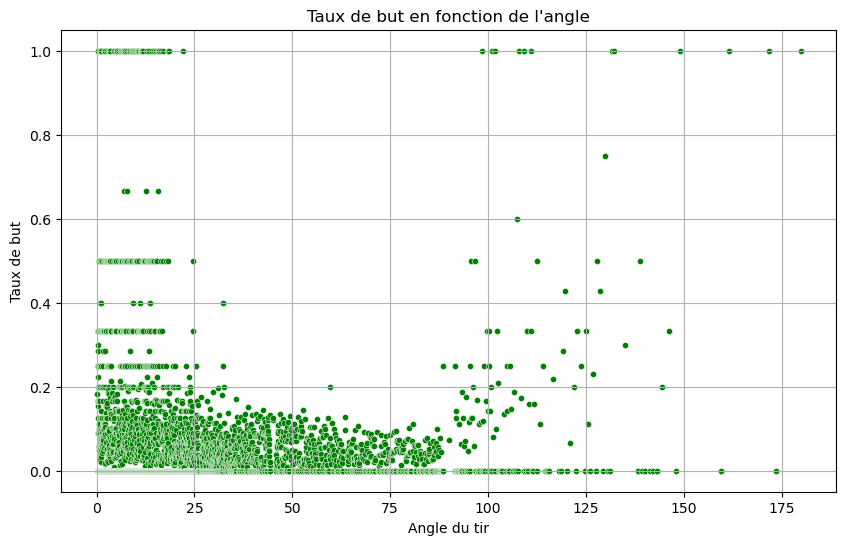

In [16]:
scatterplot_2_variables(df=df_angle_goal_rate, x='shotAngle', y='goalRate',color='green', s=20, title='Taux de but en fonction de l\'angle', xlabel='Angle du tir', ylabel='Taux de but')

## Question 3

#### Verifier but net non vide sur l'équipe adverse depuis l'intérieur de votre zone défensive

C:\Users\maciu\OneDrive - Universite de Montreal\Documents\1-UNIVERSITE DE MONTREAL\1-COURS\2- Automne 2024\IFT6758 - Data Science\1- IFT 6758 A\4- Projet\IFT6758-A11-Milestone2_14 Nov\src\visualisations\basicVisualisations\basicVisualisation.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Empty net'] = data['emptyGoalNet']


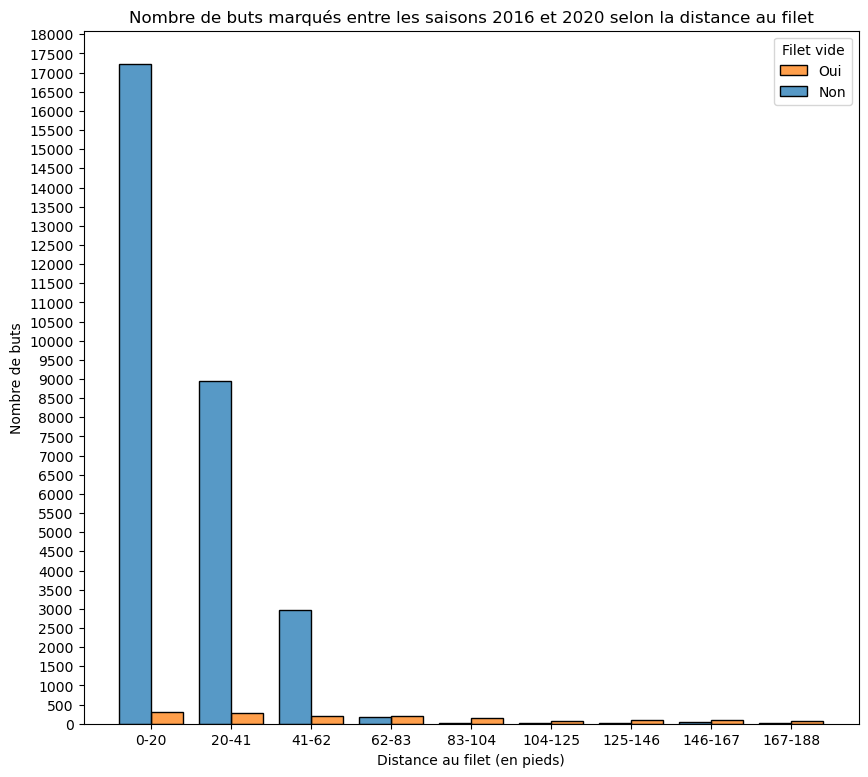

In [17]:
plot_goals_by_distance(train_data)

In [18]:
faraway_goals = train_data[(train_data['shotDistance'] > 30) & (train_data['typeDescKey'] == 'goal')]

grouped_df = faraway_goals.groupby(['shotType']).count()

print(grouped_df['idGame'])

shotType
backhand        115
deflected        84
slap           2409
snap           1483
tip-in           91
wrap-around       2
wrist          4011
Name: idGame, dtype: int64


In [19]:
faraway_goals[faraway_goals['shotType'] == 'wrap-around']

,Year,idGame,gameType,periodType,currentPeriod,timeInPeriod,eventOwnerTeam,typeDescKey,iceCoord,zoneShoot,...,goaliePlayer,shotType,teamSide,emptyGoalNet,isGoalAdvantage,shotDistance,shotAngle,timeSinceLastShot,isGoal,emptyGoalNet_0_1
47255,2016,2016020779,regular-season,REG,3/3,2017-02-05 01:59:42+00:00,Penguins,goal,"(3, 1)",N,...,NaN,wrap-around,away,True,Disadvantage,92.0,0.622756,1:41,1,1
135239,2017,2017020853,regular-season,REG,3/3,2018-02-11 17:57:12+00:00,Penguins,goal,"(-52, -32)",O,...,NaN,wrap-around,away,True,Disadvantage,48.9,40.855376,3:49,1,1


In [20]:
# pour l'evenement 47255 du match 2016020779, le type de tir n'est pas correct car un wrap-around ne peut pas se faire aussi loin
# voir: https://www.nhl.com/gamecenter/pit-vs-stl/2017/02/04/2016020779/playbyplay
# pour l'evenement 135239 du match 2017020853, le type de tir n'est pas correct car un wrap-around ne peut pas se faire aussi loin
# voir: https://www.nhl.com/gamecenter/pit-vs-stl/2018/02/11/2017020853/playbyplay

# video wrap-around: https://www.youtube.com/watch?v=tmRibUXW8RE

In [21]:
defensive_zone_goals = train_data[(train_data['shotDistance'] > 80) & (train_data['typeDescKey'] == 'goal')]

grouped_df = defensive_zone_goals.groupby(['shotType','emptyGoalNet']).count()

print(grouped_df['idGame'])

shotType     emptyGoalNet
backhand     False             9
             True             35
deflected    False             2
slap         False            20
             True             19
snap         False            17
             True             34
tip-in       False            17
             True              1
wrap-around  True              1
wrist        False            64
             True            449
Name: idGame, dtype: int64


In [22]:
defensive_zone_goals[(defensive_zone_goals['shotType'] == 'backhand') & (defensive_zone_goals['emptyGoalNet'] == False)]

,Year,idGame,gameType,periodType,currentPeriod,timeInPeriod,eventOwnerTeam,typeDescKey,iceCoord,zoneShoot,...,goaliePlayer,shotType,teamSide,emptyGoalNet,isGoalAdvantage,shotDistance,shotAngle,timeSinceLastShot,isGoal,emptyGoalNet_0_1
54362,2016,2016020894,regular-season,SO,5/3,2017-02-24 01:50:00+00:00,Rangers,goal,"(-71, 5)",O,...,Frederik Andersen,backhand,away,False,Advantage,160.1,1.789911,15:04,1,0
80622,2017,2017020004,regular-season,REG,1/3,2017-10-05 02:47:17+00:00,Sharks,goal,"(-84, -5)",O,...,Brian Elliott,backhand,home,False,Neutral,173.1,1.655487,0:02,1,0
80645,2017,2017020004,regular-season,REG,3/3,2017-10-05 03:13:12+00:00,Sharks,goal,"(-91, 12)",O,...,Brian Elliott,backhand,home,False,Advantage,180.4,3.814075,1:53,1,0
106921,2017,2017020413,regular-season,SO,5/3,2017-12-05 01:50:00+00:00,Islanders,goal,"(-82, -3)",O,...,James Reimer,backhand,away,False,Advantage,171.0,1.005086,0:00,1,0
120465,2017,2017020625,regular-season,REG,2/3,2018-01-05 02:27:30+00:00,Flames,goal,"(69, -16)",D,...,Jonathan Quick,backhand,home,False,Neutral,158.8,5.782392,0:01,1,0
120566,2017,2017020626,regular-season,SO,5/3,2018-01-05 03:20:00+00:00,Oilers,goal,"(-78, -1)",O,...,John Gibson,backhand,home,False,Advantage,167.0,0.343084,18:07,1,0
136321,2017,2017020870,regular-season,REG,1/3,2018-02-14 00:43:32+00:00,Red Wings,goal,"(30, 5)",D,...,John Gibson,backhand,home,False,Neutral,119.1,2.405971,7:49,1,0
196129,2018,2018020452,regular-season,REG,2/3,2018-12-09 01:25:10+00:00,Sharks,goal,"(-80, 0)",D,...,Adin Hill,backhand,away,False,Neutral,169.0,0.000000,1:16,1,0
225961,2018,2018020924,regular-season,SO,5/3,2019-02-20 03:20:00+00:00,Coyotes,goal,"(83, 3)",O,...,Mikko Koskinen,backhand,away,False,Advantage,172.0,0.999244,15:06,1,0


In [23]:
# l'venement 54362 du match 2016020894 n'a pas les bonnes coordonées. 
# voir la vidéo: https://www.youtube.com/watch?v=lM6JXVW0-YY du match. le but de Mats Zuccarello en période de shoot-out
# est fait du coté droit, non du coté gauche

# l'evenemnt 80622 du match 2017020004 n'a pas les bonnes coordonées.
# voir la vidéo: https://www.youtube.com/watch?v=WpIGr7srlLY. le but de Kevin Labanc est du mauvais coté

In [24]:
defensive_zone_goals[(defensive_zone_goals['emptyGoalNet'] == False) & (defensive_zone_goals['shotDistance'] > 110)]

,Year,idGame,gameType,periodType,currentPeriod,timeInPeriod,eventOwnerTeam,typeDescKey,iceCoord,zoneShoot,...,goaliePlayer,shotType,teamSide,emptyGoalNet,isGoalAdvantage,shotDistance,shotAngle,timeSinceLastShot,isGoal,emptyGoalNet_0_1
1806,2016,2016020030,regular-season,REG,3/3,2016-10-16 22:47:59+00:00,Islanders,goal,"(33, 21)",D,...,John Gibson,wrist,home,False,Neutral,123.8,9.766679,0:00,1,0
6170,2016,2016020103,regular-season,SO,5/3,2016-10-28 01:20:00+00:00,Blues,goal,"(-61, 20)",O,...,Petr Mrazek,wrist,home,False,Advantage,151.3,7.594643,16:41,1,0
17379,2016,2016020287,regular-season,SO,5/3,2016-11-23 04:20:00+00:00,Ducks,goal,"(-40, -10)",D,...,Thomas Greiss,wrist,home,False,Advantage,129.4,4.432668,0:00,1,0
20743,2016,2016020342,regular-season,REG,2/3,2016-12-01 01:22:10+00:00,Islanders,goal,"(-37, -16)",D,...,Matt Murray,tip-in,home,False,Neutral,127.0,7.236922,0:01,1,0
20777,2016,2016020342,regular-season,REG,3/3,2016-12-01 01:53:08+00:00,Penguins,goal,"(-63, 15)",D,...,Thomas Greiss,wrist,away,False,Neutral,152.7,5.635941,2:00,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
273604,2019,2019020316,regular-season,REG,3/3,2019-11-19 00:58:49+00:00,Capitals,goal,"(33, 39)",D,...,NaN,tip-in,home,False,Neutral,128.1,17.727629,2:57,1,0
291708,2019,2019020602,regular-season,REG,3/3,2019-12-29 20:59:30+00:00,Blues,goal,"(-30, 39)",D,...,NaN,wrist,home,False,Neutral,125.2,18.145579,3:12,1,0
310348,2019,2019020898,regular-season,REG,3/3,2020-02-15 21:58:02+00:00,Oilers,goal,"(-76, 34)",D,...,NaN,slap,away,False,Neutral,168.5,11.643431,4:03,1,0
316827,2019,2019021001,regular-season,REG,2/3,2020-02-29 21:33:14+00:00,Kings,goal,"(-77, 5)",O,...,Mackenzie Blackwood,wrist,home,False,Neutral,166.1,1.725255,0:42,1,0


In [25]:
# l'evenemnet 1806 n,est pas le bon zoneShoot/zoneCode. il a comme zoneShoot D (defensive) alors que quand on regarde le but de
# John Tavares, il le marque bien dans la zone offensive https://www.youtube.com/watch?v=MO7vAygX2_c

# Modèles de base

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

#### Préparation de la caractéristique et de la cible

In [27]:
# Préparation de la caractéristique et de la cible
X = train_data[['shotDistance']].dropna()
y = train_data['isGoal'][X.index]

In [28]:
# Division des données en ensembles d'entraînement et de validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [29]:
# # Vérification des types et absence de NaN
# print("Type de X_train:", type(X_train))
# print("Type de y_train:", type(y_train))
# print("Valeurs manquantes dans X_train:", X_train.isnull().sum().sum())
# print("Valeurs manquantes dans y_train:", y_train.isnull().sum())

#### Entraîner le modèle

In [30]:
clf = LogisticRegression()
clf.fit(X_train, y_train)

LogisticRegression()

#### Prédiction et évaluation

In [31]:
# Prédiction et évaluation
y_pred = clf.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
print(f"Précision du modèle sur l'ensemble de validation: {accuracy:.2f}")

Précision du modèle sur l'ensemble de validation: 0.91
